In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import cv2

2023-01-28 21:06:31.710422: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
model = keras.models.load_model('Final Work/segmentation_model')

In [9]:
source_dir = 'Test/Images/'
target_dir = 'Final Work/Testing/'

In [10]:
images = os.listdir(source_dir)
images.remove('.DS_Store')

In [11]:
from tensorflow.keras.preprocessing.image import load_img
for image in images:
    x = np.zeros((1,) + (256, 256) + (3,), dtype="float32")
    img_path = source_dir + image
    image_ = np.array(load_img(img_path, target_size=(256,256)))
    x[0] = image_/255.
    mask = np.array(model.predict(x, batch_size=1))*255
    mask = mask.astype(int)
    processed_image = np.bitwise_and(image_, mask[0])
    cv2.imwrite(target_dir + image, processed_image)

1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 277ms/step


In [16]:
def bounding_box(image_name):
    img = cv2.imread(target_dir + image_name, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img,(224, 224))
    thresh = cv2.threshold(img,32,255,cv2.THRESH_BINARY)[1]
    result = img.copy()
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    cntsSorted = sorted(contours, key=lambda x: cv2.contourArea(x))
    count = 0
    for cntr in cntsSorted[-2:]:
        count += 1
        x,y,w,h = cv2.boundingRect(cntr)
        area = cv2.contourArea(cntr)
        if area < 1000.0:
            print(f"Couldn't complete for {image_name}")
            break
        cv2.rectangle(result, (x, y), (x+w, y+h), (0, 0, 255), 2)
        cropped_image = img[y:y+h, x:x+w]
        name = image_name + '_' + str(count)
        cv2.imwrite(f'./Final Work/Testing_BoundingBox/{name}.png', cropped_image)

In [18]:
if not os.path.exists("./Final Work/Testing_BoundingBox"):
    os.mkdir('./Final Work/Testing_BoundingBox')
    all_images = os.listdir(target_dir)
    for image in all_images:
        bounding_box(image)

Couldn't complete for COVID-698.png
Couldn't complete for COVID-2762.png


In [24]:
all_lungs = os.listdir('./Test/Testing_BoundingBox')
all_lungs.remove('.DS_Store')
len(all_lungs)

259

In [21]:
covid_count = 0
normal_count = 0
for i in all_lungs:
    if i[0] == 'C': covid_count += 1
    if i[0] == 'N': normal_count += 1

In [22]:
covid_count

122

In [23]:
normal_count

137

In [4]:
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import kurtosis, skew 
import pandas as pd
import numpy as np
import cv2

SIZE = 224

def machine_learning_feature_extractor(dataset, type_data):
    image_dataset = pd.DataFrame()
    base_dir = f'./{type_data}/'
    for image_path in dataset:   
        df = pd.Series([image_path])
        gray = cv2.imread(base_dir + image_path, cv2.IMREAD_GRAYSCALE)
        gray = cv2.resize(gray, (SIZE, SIZE))
#         gray = normalize(gray).astype(np.uint8)
        # Process GLCM features
        all_angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
        count = 0
        for i in all_angles:
            count += 1
            GLCM = graycomatrix(gray, [1], [i])
            GLCM_Energy = graycoprops(GLCM, 'energy')[0]
            df['Energy' + str(count)] = GLCM_Energy
            GLCM_corr = graycoprops(GLCM, 'correlation')[0]
            df['Corr' + str(count)] = GLCM_corr
            GLCM_diss = graycoprops(GLCM, 'dissimilarity')[0]
            df['Diss_sim' + str(count)] = GLCM_diss
            GLCM_hom = graycoprops(GLCM, 'homogeneity')[0]
            df['Homogen'+ str(count)] = GLCM_hom
            GLCM_contr = graycoprops(GLCM, 'contrast')[0]
            df['Contrast' + str(count)] = GLCM_contr
            GLCM_ASM = graycoprops(GLCM, 'ASM')[0]
            df['ASM' + str(count)] = GLCM_ASM
            GLCM_Corr = graycoprops(GLCM, 'correlation')[0]
            df['correlation' + str(count)] = GLCM_Corr
        
        # First order statistics
        gray_masked =  np.ma.masked_equal(gray, 0.0, copy=False)
        df['Min'] = gray_masked.min()
        df['Max'] = gray_masked.max()
        df['Mean'] = gray_masked.mean()
        df['Std'] = gray_masked.std()
        df['Var'] = gray_masked.var()
        gray_masked_ = gray_masked.reshape(-1)
        df['Skew'] = skew(gray_masked_)
        df['Kurtosis'] = kurtosis(gray_masked_)
        
        # Process histogram features
        histogram, _ = np.histogram(gray_masked, bins=10)
        histogram = pd.Series(histogram)
        df = df.append(histogram, ignore_index=True)
        image_dataset = image_dataset.append(df, ignore_index=True) 
        
    return image_dataset

In [ ]:
ML_features = machine_learning_feature_extractor(all_lungs, './Test/Testing_BoundingBox')

In [27]:
ML_features

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,Normal-62.png_2.png,[0.3053302898949905],[0.9956315013719202],[1.753683536194747],[0.6315847031406676],[21.70367552850736],[0.09322658592735893],[0.9956315013719202],[0.29401068446588513],[0.9851131469679515],...,18903,595,491,810,4140,6818,6685,6001,4559,1174
1,COVID-2439.png_2.png,[0.3530352750587816],[0.996328888311202],[1.9278307174887892],[0.6792476040410262],[35.161895419602814],[0.12463390543582957],[0.996328888311202],[0.3435107139156966],[0.9882734131610212],...,22402,1035,344,315,268,650,5561,9711,6053,3837
2,COVID-720.png_1.png,[0.3028870345836614],[0.9959766156094121],[1.839385810377963],[0.6696228119904505],[26.28181053811659],[0.0917405557188841],[0.9959766156094121],[0.2923481968972435],[0.9947084039511294],...,24412,1327,1040,2656,5402,6720,5274,2037,881,427
3,COVID-1676.png_2.png,[0.29005045260329393],[0.9898887834084423],[2.0680853619474697],[0.5693358539839359],[25.13731181934657],[0.08412926505537564],[0.9898887834084423],[0.28285433953490596],[0.972675052915799],...,17057,1479,6704,10673,6740,3882,2235,878,469,59
4,Normal-317.png_1.png,[0.44744291770790795],[0.9955803567832828],[1.7385289878283152],[0.6720077955322961],[22.919742953235104],[0.20020516460696566],[0.9955803567832828],[0.44277956824356673],[0.9904896014612719],...,24975,1220,3850,5671,5966,3857,2161,1617,733,126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,Normal-2949.png_2.png,[0.27660629836007555],[0.9946603712702377],[2.3150224215246635],[0.6033727289987932],[43.56506245996156],[0.07651104429246312],[0.9946603712702377],[0.2696128130966481],[0.9834771558191848],...,15798,514,383,594,4505,10773,7960,5893,2876,880
255,COVID-2779.png_1.png,[0.41454814574420246],[0.9961594786659883],[2.117833119795003],[0.6348503534950637],[33.70912075592569],[0.17185016513995652],[0.9961594786659883],[0.41172302294489915],[0.9950289949548149],...,22656,725,2583,4990,3967,4135,4123,3235,2209,1553
256,COVID-2315.png_1.png,[0.3743929494180622],[0.9970235720193239],[1.6106662395900062],[0.69817778112422],[20.68477738629084],[0.14017008057395572],[0.9970235720193239],[0.36968742044320596],[0.9951918661087974],...,22974,642,468,417,806,4255,7689,6877,4210,1838
257,Normal-485.png_1.png,[0.3489516414858193],[0.9966768951205548],[1.8603058936579115],[0.6256581553399572],[18.198070147341443],[0.12176724809564776],[0.9966768951205548],[0.3394644372346892],[0.9916490040327486],...,24410,1287,2556,5114,6234,5993,3165,1047,274,96


In [30]:
ML_features.to_csv('Testing_ML.csv', index=False)

In [31]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras import models, layers

model = VGG16(weights="imagenet", include_top=True)

layer1 = model.get_layer("fc1").output
layer2 = model.get_layer("fc2").output

intermediate_model1 = models.Model(inputs=model.input, outputs=layer1)
intermediate_model2 = models.Model(inputs=model.input, outputs=layer2)

# intermediate_model1.summary()
# intermediate_model2.summary()

In [32]:
SIZE = 224
def deep_learning_feature_extractor(dataset, type_data, intermediate_model1, intermediate_model2):
    image_dataset = pd.DataFrame()
    count_ = 0
    base_dir = f'./{type_data}/'
    for image_path in dataset:   
        count_ += 1
        if count_ % 200 == 0:
            print('200 images processed...')
        df = pd.Series([image_path])

        img = cv2.imread(base_dir + image_path)
        img = cv2.resize(img, (SIZE, SIZE))
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
        
        feature_set1 = pd.Series(intermediate_model1.predict(img)[0])
        df = df.append(feature_set1, ignore_index=True)
        feature_set2 = pd.Series(intermediate_model2.predict(img)[0])
        df = df.append(feature_set2, ignore_index=True)
        image_dataset = image_dataset.append(df, ignore_index=True)
    print('Finished Processing...')
    return image_dataset

In [ ]:
DL_features = deep_learning_feature_extractor(all_lungs, 'Test/Testing_BoundingBox', intermediate_model1, intermediate_model2)

In [35]:
DL_features

,0,1,2,3,4,5,6,7,8,9,...,8183,8184,8185,8186,8187,8188,8189,8190,8191,8192
0,Normal-62.png_2.png,0.0,0.000000,0.0,0.0,0.0,0.000000,0.555297,0.000000,1.144847,...,0.000000,0.615825,0.658562,0.000000,0.322149,0.000000,0.000000,3.010976,1.533874,0.304558
1,COVID-2439.png_2.png,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.340638,0.000000,...,2.719131,0.000000,0.255476,0.000000,1.835483,0.000000,0.000000,3.650980,0.479435,0.000000
2,COVID-720.png_1.png,0.0,0.000000,0.0,0.0,0.0,0.383405,2.775242,0.000000,0.409339,...,0.901119,1.141475,3.699650,0.205722,0.000000,0.000000,0.000000,4.697048,0.953284,0.000000
3,COVID-1676.png_2.png,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,3.371100,...,0.316962,0.138161,0.643081,0.000000,0.444053,0.324594,0.000000,1.098251,1.442501,0.000000
4,Normal-317.png_1.png,0.0,0.000000,0.0,0.0,0.0,0.000000,3.138755,0.000000,0.598429,...,1.456688,1.528902,1.587115,0.450458,1.212270,0.000000,0.000000,3.155626,2.493989,0.661671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,Normal-2949.png_2.png,0.0,0.000000,0.0,0.0,0.0,0.000000,4.203412,0.000000,0.000000,...,1.036447,1.719857,0.401955,0.385324,1.149404,0.644962,0.000000,2.762407,2.235460,0.421031
255,COVID-2779.png_1.png,0.0,0.000000,0.0,0.0,0.0,0.000000,5.371396,3.108063,0.000000,...,1.557574,1.210979,1.077178,0.543690,0.868781,0.000000,0.000000,3.846579,1.952781,0.226984
256,COVID-2315.png_1.png,0.0,0.152162,0.0,0.0,0.0,0.000000,6.461157,2.830865,0.093986,...,1.652880,0.939775,0.845779,0.374002,0.131056,0.000000,0.000000,2.785501,2.579906,0.000000
257,Normal-485.png_1.png,0.0,0.000000,0.0,0.0,0.0,0.000000,2.567626,0.000000,3.557112,...,0.153434,0.128499,1.634384,0.000000,0.000000,0.000000,0.580687,4.114489,0.785174,0.565519


In [36]:
DL_features.to_csv('Testing_DL.csv', index=False)

In [7]:
data_ML = pd.read_csv('TestingSet_MLFeatures.csv')
data_DL = pd.read_csv('TestingSet_DLFeatures.csv')

In [8]:
data_ML

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,COVID-2572.png_1.png,[0.39575756],[0.99246526],[2.10764334],[0.6296385],[30.20862028],[0.15662405],[0.99246526],[0.38896977],[0.9800366],...,24159,915,1236,3453,6213,6241,4776,2099,877,207
1,Normal-3972.png_2.png,[0.34338329],[0.99487322],[2.19418642],[0.6281141],[40.81914638],[0.11791209],[0.99487322],[0.33712988],[0.98593355],...,19165,452,340,1351,5678,9630,5940,4173,2425,1022
2,Normal-4249.png_2.png,[0.29077897],[0.99377052],[1.73352418],[0.63931851],[20.80627402],[0.08455241],[0.99377052],[0.28370702],[0.98282754],...,16814,978,5737,7866,10137,5316,2109,841,332,46
3,Normal-2979.png_1.png,[0.4006652],[0.99460422],[1.72297406],[0.66878861],[24.30873639],[0.16053261],[0.99460422],[0.39499216],[0.99466279],...,24975,5361,6038,4202,2700,2434,1692,1512,981,281
4,COVID-2434.png_1.png,[0.34578359],[0.99572018],[1.89946348],[0.64524697],[27.28719571],[0.11956629],[0.99572018],[0.33876454],[0.98717849],...,22013,700,410,1069,3560,5960,6674,4716,3772,1302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,COVID-1966.png_2.png,[0.32528341],[0.99641058],[1.84220852],[0.67021133],[28.63252723],[0.1058093],[0.99641058],[0.31691833],[0.98887078],...,22780,837,346,353,354,3170,7694,8711,4819,1112
2948,Normal-600.png_1.png,[0.39027592],[0.99435178],[1.90038437],[0.64477897],[21.21893017],[0.15231529],[0.99435178],[0.37691969],[0.98629487],...,28061,3058,3551,5167,3663,2960,2174,1000,483,59
2949,Normal-4454.png_2.png,[0.3003618],[0.99548903],[2.18717969],[0.62485943],[40.59881486],[0.09021721],[0.99548903],[0.29357583],[0.98603747],...,16958,511,391,581,3318,6765,9718,8330,3024,580
2950,Normal-6498.png_2.png,[0.20197812],[0.99449343],[1.57701393],[0.67198909],[18.94688901],[0.04079516],[0.99449343],[0.18848871],[0.99092568],...,14786,832,842,809,2067,9520,12086,6316,1963,955


In [9]:
to_change = [i for i in data_ML.columns if data_ML[i].dtype != np.float64]
to_change.remove('0')

In [ ]:
for i in to_change:
    data_ML[i] = data_ML[i][0].astype(np.float64)

In [ ]:
merged = pd.merge(data_ML, data_DL, how='inner', on='0')

def convert_to_class(val):
    if val[:5] == "COVID":
        return 1
    else: return 0

merged['class'] = merged['0'].map(convert_to_class)

In [ ]:
merged

,0,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,8184,8185,8186,8187,8188,8189,8190,8191,8192,class
0,Normal-62.png_2.png,0.30533,0.995632,1.753684,0.631585,21.703676,0.093227,0.995632,0.294011,0.985113,...,0.615825,0.658562,0.000000,0.322149,0.000000,0.000000,3.010976,1.533874,0.304558,0
1,COVID-2439.png_2.png,0.30533,0.995632,1.753684,0.631585,21.703676,0.093227,0.995632,0.294011,0.985113,...,0.000000,0.255476,0.000000,1.835483,0.000000,0.000000,3.650980,0.479435,0.000000,1
2,COVID-720.png_1.png,0.30533,0.995632,1.753684,0.631585,21.703676,0.093227,0.995632,0.294011,0.985113,...,1.141475,3.699650,0.205722,0.000000,0.000000,0.000000,4.697048,0.953284,0.000000,1
3,COVID-1676.png_2.png,0.30533,0.995632,1.753684,0.631585,21.703676,0.093227,0.995632,0.294011,0.985113,...,0.138161,0.643081,0.000000,0.444053,0.324594,0.000000,1.098251,1.442501,0.000000,1
4,Normal-317.png_1.png,0.30533,0.995632,1.753684,0.631585,21.703676,0.093227,0.995632,0.294011,0.985113,...,1.528902,1.587115,0.450458,1.212270,0.000000,0.000000,3.155626,2.493989,0.661671,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,Normal-2949.png_2.png,0.30533,0.995632,1.753684,0.631585,21.703676,0.093227,0.995632,0.294011,0.985113,...,1.719857,0.401955,0.385324,1.149404,0.644962,0.000000,2.762407,2.235460,0.421031,0
255,COVID-2779.png_1.png,0.30533,0.995632,1.753684,0.631585,21.703676,0.093227,0.995632,0.294011,0.985113,...,1.210979,1.077178,0.543690,0.868781,0.000000,0.000000,3.846579,1.952781,0.226984,1
256,COVID-2315.png_1.png,0.30533,0.995632,1.753684,0.631585,21.703676,0.093227,0.995632,0.294011,0.985113,...,0.939775,0.845779,0.374002,0.131056,0.000000,0.000000,2.785501,2.579906,0.000000,1
257,Normal-485.png_1.png,0.30533,0.995632,1.753684,0.631585,21.703676,0.093227,0.995632,0.294011,0.985113,...,0.128499,1.634384,0.000000,0.000000,0.000000,0.580687,4.114489,0.785174,0.565519,0


In [48]:
merged.to_csv('TestingSet_AllFeatures.csv', index=False)

In [11]:
import pandas as pd
merged = pd.read_csv('TestingSet_AllFeatures.csv')

In [12]:
merged

,0,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,8184,8185,8186,8187,8188,8189,8190,8191,8192,class
0,COVID-2572.png_1.png,0.395758,0.992465,2.107643,0.629638,30.208620,0.156624,0.992465,0.388970,0.980037,...,0.330646,2.070924,0.998942,0.145498,0.000000,0.000000,1.661526,0.598723,0.000000,1
1,Normal-3972.png_2.png,0.343383,0.994873,2.194186,0.628114,40.819146,0.117912,0.994873,0.337130,0.985934,...,1.517159,0.408448,0.000000,0.208283,0.000000,0.000000,2.884195,2.023928,0.000000,0
2,Normal-4249.png_2.png,0.290779,0.993771,1.733524,0.639319,20.806274,0.084552,0.993771,0.283707,0.982828,...,1.509870,0.076002,0.000000,1.169973,0.352332,0.000000,3.117625,2.408634,0.975338,0
3,Normal-2979.png_1.png,0.400665,0.994604,1.722974,0.668789,24.308736,0.160533,0.994604,0.394992,0.994663,...,0.456448,1.579361,0.000000,0.000000,0.000000,0.000000,2.107385,1.166255,0.000000,0
4,COVID-2434.png_1.png,0.345784,0.995720,1.899463,0.645247,27.287196,0.119566,0.995720,0.338765,0.987178,...,0.000000,0.850063,0.000000,0.000000,0.000000,0.000000,2.821785,2.332961,0.166518,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,COVID-1966.png_2.png,0.325283,0.996411,1.842209,0.670211,28.632527,0.105809,0.996411,0.316918,0.988871,...,0.000000,0.250614,0.000000,0.000000,0.000000,0.000000,4.999744,1.774077,0.000000,1
2948,Normal-600.png_1.png,0.390276,0.994352,1.900384,0.644779,21.218930,0.152315,0.994352,0.376920,0.986295,...,1.315942,1.519322,0.000000,0.110842,0.000000,0.000000,1.968208,1.023638,0.039039,0
2949,Normal-4454.png_2.png,0.300362,0.995489,2.187180,0.624859,40.598815,0.090217,0.995489,0.293576,0.986037,...,1.212696,1.349979,0.313824,0.611010,0.302460,0.000000,3.465905,2.884601,0.000000,0
2950,Normal-6498.png_2.png,0.201978,0.994493,1.577014,0.671989,18.946889,0.040795,0.994493,0.188489,0.990926,...,2.418075,2.174892,0.447814,0.966600,0.000000,0.518620,5.145925,3.005331,1.445446,0


In [13]:
import pickle
to_keep = pickle.load(open('features_select', 'rb'))
model = pickle.load(open('SVM_model.sav', 'rb'))

In [14]:
df_features = merged[to_keep]
df_targets = merged['class']

In [15]:
df_features

,5_x,12_x,19_x,26_x,30_x,31_x,32_x,37_x,38_x,39_x,...,8120,8121,8126,8134,8141,8150,8151,8160,8163,8176
0,30.208620,80.078445,30.788717,36.500050,159,72.188933,35.425438,915,1236,3453,...,3.696424,3.360985,3.742858,1.321684,1.806385,3.401641,0.978251,2.529928,0.391837,1.898501
1,40.819146,111.841320,43.522001,52.673611,202,114.585861,39.258910,452,340,1351,...,2.868357,1.749615,6.507771,1.464443,2.385707,3.361501,3.348090,3.856288,3.588393,0.494466
2,20.806274,57.251986,25.550428,33.112892,180,71.722518,29.235174,978,5737,7866,...,2.656489,1.965344,6.910876,1.622970,4.078469,1.641052,2.735409,3.628511,1.136055,0.000000
3,24.308736,24.089626,19.503563,61.147218,197,64.971108,45.586494,5361,6038,4202,...,0.026133,2.389837,4.964719,2.857697,2.224899,0.322583,1.464046,3.286284,1.841892,3.026483
4,27.287196,81.715599,34.756226,38.630477,168,92.447311,43.729645,700,410,1069,...,3.151665,1.156311,6.005597,1.080866,1.169798,3.688038,2.967611,3.735679,3.846773,0.332720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,28.632527,88.746566,38.620115,42.075509,176,100.313253,51.294608,837,346,353,...,4.895128,1.233991,5.749032,1.357871,0.936238,2.662610,3.168404,3.636804,2.056943,0.000000
2948,21.218930,51.573549,54.716628,95.926341,186,56.930239,42.688651,3058,3551,5167,...,2.427927,3.098303,5.788270,1.863860,2.804832,0.657699,0.345104,2.190185,1.526191,0.202536
2949,40.598815,125.302540,57.546485,67.120393,208,127.039522,39.603577,511,391,581,...,3.309026,0.821795,4.861274,0.531134,2.250607,2.363245,4.002609,3.057799,4.950803,0.000000
2950,18.946889,31.103360,20.554592,45.047638,136,75.079104,31.905277,832,842,809,...,4.704020,3.457873,7.849541,2.637933,4.290973,0.823593,2.248934,4.375416,1.489732,0.470912


In [16]:
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
scaler = preprocessing.StandardScaler().fit(df_features)
df_features_scaled = scaler.transform(df_features)

In [17]:
predictions = model.predict(df_features_scaled)

In [18]:
print('Accuracy: %.3f' % accuracy_score(np.ravel(df_targets), predictions))
print('Precision: %.3f' % precision_score(np.ravel(df_targets), predictions))
print('Recall: %.3f' % recall_score(np.ravel(df_targets), predictions))

Accuracy: 0.847
Precision: 0.849
Recall: 0.843


In [19]:
confusion_matrix(np.ravel(df_targets), predictions)

array([[1255,  221],
       [ 232, 1244]])

In [16]:
# Function Definition --> Plotting the AUC-ROC Curve

def Plotting_AUC_ROC_Curve(y, preds):
    import sklearn.metrics as metrics
    import matplotlib.pyplot as plt

    fpr, tpr, threshold = metrics.roc_curve(y, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])

    plt.title('Receiver Operating Characteristic')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    plt.show()
    plt.savefig('./AUC-ROC_Graph_Model.png')

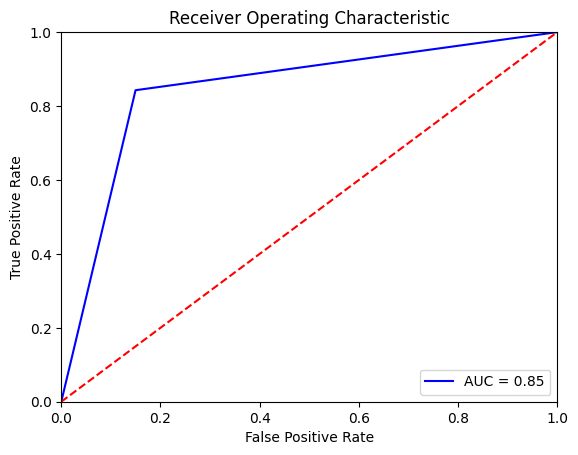

<Figure size 640x480 with 0 Axes>

In [17]:
Plotting_AUC_ROC_Curve(np.ravel(df_targets), predictions)

In [14]:
y = model.decision_function(df_features_scaled)
w_norm = np.linalg.norm(model.coef_)
distance_from_hyperplane = y / w_norm

In [15]:
sigmoid_distance = 1/(1 + np.exp(-distance_from_hyperplane))

In [16]:
sigmoid_distance

array([0.61065013, 0.416287  , 0.5755459 , ..., 0.54413087, 0.45449228,
       0.64473012])

In [17]:
distance_data = pd.DataFrame()
distance_data['image'] = merged['0']
distance_data['dist'] = sigmoid_distance

In [19]:
training_data = pd.read_csv('scan_distfromhyperplane.csv')

In [20]:
training_data

,image,dist
0,COVID-551.png_1.png,0.858388
1,Normal-4457.png_1.png,0.244383
2,COVID-3271.png_2.png,0.532642
3,Normal-4688.png_1.png,0.420804
4,COVID-285.png_2.png,0.532629
...,...,...
11243,Normal-3782.png_1.png,0.348924
11244,Normal-8372.png_2.png,0.467374
11245,Normal-6384.png_1.png,0.383358
11246,Normal-2349.png_1.png,0.362737


In [21]:
def get_closest_case(name, dist):
    to_check = training_data['dist']-dist
    closest_val = to_check.abs().min()
    index_at = training_data.index[to_check.abs() == closest_val].tolist()[0]
    return ((name, dist), (training_data['image'][index_at], training_data['dist'][index_at]))

In [22]:
test_data = (distance_data['image'].to_numpy(), distance_data['dist'].to_numpy())

In [23]:
closest_case_for_test = []
for i in range(len(test_data[0])):
    closest_case_for_test.append(get_closest_case(test_data[0][i], test_data[1][i]))

In [24]:
closest_case_for_test

[(('COVID-2572.png_1.png', 0.6106501289274421),
  ('COVID-2664.png_1.png', 0.610677036691159)),
 (('Normal-3972.png_2.png', 0.41628700492935294),
  ('Normal-7282.png_2.png', 0.416270355458082)),
 (('Normal-4249.png_2.png', 0.5755459010248909),
  ('COVID-2917.png_1.png', 0.575548736521187)),
 (('Normal-2979.png_1.png', 0.3488495540665629),
  ('Normal-10186.png_1.png', 0.3488610699092208)),
 (('COVID-2434.png_1.png', 0.5980126331196621),
  ('COVID-1245.png_1.png', 0.5979802496579102)),
 (('COVID-388.png_2.png', 0.5756095259165945),
  ('COVID-1400.png_1.png', 0.57555463079148)),
 (('Normal-156.png_2.png', 0.45352949885427185),
  ('COVID-2068.png_2.png', 0.4534970381653901)),
 (('COVID-2922.png_2.png', 0.5362212107047152),
  ('Normal-8581.png_2.png', 0.5362622205629206)),
 (('Normal-2235.png_2.png', 0.4828037100255225),
  ('Normal-4537.png_1.png', 0.4828111455935018)),
 (('Normal-4134.png_1.png', 0.2696072741273981),
  ('Normal-237.png_2.png', 0.2695881012202845)),
 (('Normal-5623.png_2.pn

In [25]:
pickle.dump(closest_case_for_test, open('image_same_to_test', 'wb'))

In [28]:
true_positive, false_positive, false_negative, true_negative = 0, 0, 0, 0
for i in closest_case_for_test:
    if i[0][0][0] == 'C' and i[1][0][0] == 'C':
        true_positive += 1
    elif i[0][0][0] == 'C' and i[1][0][0] == 'N':
        false_positive += 1
    elif i[0][0][0] == 'N' and i[1][0][0] == 'C':
        false_negative += 1 
    else:
        true_negative += 1

In [29]:
precision = (true_positive)/(true_positive + false_positive)
precision

0.8272357723577236

In [30]:
recall = (true_positive)/(true_positive + false_negative)
recall

0.8368745716244003

In [31]:
accuracy = (true_positive + true_negative)/(true_positive + true_negative + false_negative + false_positive)
accuracy

0.8329945799457995